# Euler project

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Introduction généraliste

* Léo : viscosité  spaciale: diffuser en fonction de la forme de la fonction. Ex fort graident
    * local ou global
    * on regarde les fonctions une à une. 
    * Selon les régime plysique, tu veux plus difuser les choses les plus rapides. Pas nécessaire en GD: il y a déjà de la viscosité physique.  Alors qu'en élément fini on est obligé de faire les 2


* Euler: viscosité physique. Couplé. Qui ne dépend que des interaction entre les variables. quel phénomène est le plus rapide, le plus fort. 
    * On s'interdit de regarder globallement.
    * On diffuse en rho, rhoV, E. 






### EDP

On se donne une fonction $F:\mathbb R^n \to \mathbb R^n $. 

On cherche une fonction $(x,t)\to w(x,t)\in \mathbb R^n$ qui satisfait à l'EDP suivante:
$$ \tag{EDP}
 \partial_t w = - \partial_x F(w)
$$
L'évolution en temps de $w$ est donnée par une dérivée spaciale de $F(w)$ que l'on appelle naturellement le flux.  

### Schéma

* On a une discrétisation temporelle $t_0,t_1,...$.  
* On a une discrétisation spaciale $x_0,x_1,...$.  
* On condisère aussi les points spaciaux du milieu. $x_{i+\frac 12}=(x_i + x_{i+1})/2$

On note
* $w^n_i = w(x_i,t_n)$
* $w^n_{i+\frac 12} = w(x_{i+\frac 12},t_n)$

L'équation $(EDP)$ s'écrit alors: 
$$
\frac 1{\delta_t} [w^{n+1}_i - w^n_i ] = - \frac 1{\delta_x} [F(w_{i+\frac 12}) - F(w_{i- \frac 12}) ]
$$
ou encore
$$
w^{n+1}_i  = w^n_i -  \frac {\delta_t}{\delta_x} [F(w_{i+\frac 12}) - F(w_{i- \frac 12}) ]
$$
Ce `step` cela nous permettra d'évoluer en temps. 

Il nous faut maintenant une fonction qui nous permette de rester toujours sur le même maillage. 
On suppose l'existance d'une fonction $F_?$ à deux variable telle que
$$
F_?(w_i,w_{i+1}) \approx  F(w_{i+\frac 12})
$$
$F_?$ est appelé le flux numérique. 

Notons
$$
F\!F_?(w_{i-1},w_i,w_{i+1}) = F_?(w_i,w_{i+1})-F_?(w_{i-1},w_{i})
$$
L'algorithme de résolution est alors: 
$$
w^{n+1}_i  = w^n_i -  \frac {\delta_t}{\delta_x} F\!F_?(w_{i-1},w_i,w_{i+1})
$$


Problème de stabilité: les erreur que produit $F_?$ se propagent au fil du temps.






### Candidat naturelle pour $F_?$. 

***NB:*** Par la suite, et jusqu'à la nouvelle intervention du temps, on se fixe un temps $t_n$. Et abrège $v_i^n,w_i^n$ par $v_i,w_i$. 

Un premier candidat naturelle pour $F_?$ est:
$$
F_?(w_i,w_{i+1}) = \frac{F(w_i)+F(w_{i+1})}{ 2} 
$$
Mais il est instable dans le temps. Pour améliorer sa stabilité on va ajouter un terme (sorte de diffusion) qui va lisser les éventuels sauts:
$$
F_?(w_i,w_{i+1}) = \frac{F(w_i)+F(w_{i+1})}{ 2}  + A(w_i,w_{i+1})(w_{i+1}-w_i)
$$
La fonction $A$ est souvent prise bilinéaire, mais nous allons considérer un réseau de neurones que l'on va entrainer pour stabiliser le schéma. 





### Canditat retenu pour la vérité terrain
Notons $F_i=F(w_i)$ et $\lambda_i=...$ on a pris pour $F_?$ la fonction:
$$
F_{HLL} (w_i,w_{i+1})=
\begin{cases}
F_{i} & \text{si } \lambda_{i} \geq 0 \\
\frac{\lambda_{i+1} F_{i} - \lambda_{i} F_{i+1} }{\lambda_{i+1}-\lambda_{i}} +
\frac{\lambda_{i+1}\lambda_{i} (w_{i+1} -  w_{i}) }{\lambda_{i+1}-\lambda_{i}}
 & \text{si } \lambda_i<0< \lambda_{i+1} \\
 F_{i+1} &\text{si } \lambda_{i+1}\leq 0 
\\
\end{cases}
$$


## Apprentissage supervisé. 

Grace à une grille très fine, nous avons réussit à calculer des séries de $v_i^n$ très précis. Nous allons pouvoir entrainer des réseaux de neurones.  









### Baseline

Un réseau de neurone $G_\theta(w_{i-1},w_i,w_{i+1})$ qui est cencé directement reproduire $v_i$. On ne le structure pas du tout. La loss associée sera diretement
$$
\mathtt{Loss}^G_i = G(w_{i-1},w_i,w_{i+1}) - v_i
$$
puis
$$
\mathtt{Loss}^G= \sum_i \mathtt{Loss}^G_i
$$



### Le réseau différence

On se donne un réseau $F_\theta(w_i,w_{i+1})$. On prend comme première loss:
$$
\mathtt{lossDiff}_i = \frac{F_\theta(w_i,w_{i+1})- F_\theta(w_{i-1},w_{i})}{\delta_x}  - v_i
$$
puis
$$
\mathtt{lossDiff} = \sum_i \mathtt{lossDiff}_i
$$
Mais avec  cette seule loss, l'apprentissage ne pourra pas converger: en ajoutant une constante à $F_\theta$ on ne change pas la loss.  

On peut alors ajouter un terme de pénalisation par exemple:
$$
\mathtt{loss}_{\alpha} = \mathtt{lossDiff}+ \alpha \sum w^2
$$








### Une seconde contraine

Mais on peut aussi penser à une seconde contrainte:

On aimerait aussi que notre réseau satisface cette contrainte: 
$$\tag{C2}
F_\theta(w_i,w_i) \approx  F(w_i)
$$
Cette contrainte est naturelle quand on se souvient que
$$
F_\theta(w(x_i),w(x_{i+1})) \text{ doit approcher } F\circ w (\frac {x_i+x_{i+1}}2)
$$
Quand le pas du maillage tend vers 0, on obtient cette seconde contrainte. Ainsi:

$$
\mathtt{loss}^{C2}=\mathtt{lossDiff}  +  \sum_i F_\theta(w_i,w_i)-F(w_i)
$$
Remarquons que cette seconde condition ne lève par complètement l'intermination: en ajoutant à $F_\theta$ une fonction $H(w_i,w_{i+1})$ qui s'annule sur la diagonale, la loss ne change pas. Il faut surement un peu pénaliser aussi. 


### Réseau addifif

C'est le réseau le plus structuré. C'est un peu l'idée des resNet: le réseau de neurone ajoute un terme à une quantité déjà bonne: 

On  considére un réseau de neurone $A_\theta$ puis
$$
F^A_\theta(w_i,w_{i+1}) = \frac{F(w_i)+F(w_{i+1})}{ 2}  + A_\theta(w_i,w_{i+1})(w_{i+1}-w_i)
$$
Remarquons que le solution $(C2)$ est automatiquement satisfaite par ce réseau. 

Ensuite on fait comme d'habitude: 
$$
\mathtt{lossDiff}^A_i =  F^A_\theta(w_i,w_{i+1}) -F^A_\theta(w_{i-1},w_{i}) - v_i  
$$
puis on pénalise: 
$$
\mathtt{loss}^A_{\alpha} = \mathtt{lossDiff}^A+ \alpha \sum w^2
$$


### Plus de points pour interpoler ? 

Pour faire une interpolation précise il faut souvent considérer les voisins plus lointains. On pourait donc prendre
$$ 
F_\theta(w_{i-1},w_i,w_{i+1},w_{i+2}) \approx F( w_{i+\frac 12})
$$
Ce qui conduirait à une différence
$$
F\!F_\theta (w_{i-2},w_{i-1},w_i,w_{i+1},w_{i+2}) \approx v_i
$$
Et comme baseline un simple réseau non structuré
$$
G_\theta (w_{i-2},w_{i-1},w_i,w_{i+1},w_{i+2}) \approx v_i
$$
Ou en poussant encore plus loin de bouchon: on pourrait tester une estimation globale en espace de type Vnet. 
$$
Vnet_\theta(w_.) \approx v_.
$$
sachant que le Vnet est une réseau de convolution, donc il peut glisser sur des données de taille arbitraire. Il produit simplement plusieurs output d'un coup. 

## Notre problème en particulier

### l'EDP


* $\rho(x,t)$ : une densité de gaz neutre. 
* $E$ : Energie totale du gaz
* $V$ : vitesse moyenne du gaz

Les inconnues sont 
* $\rho$
* $V$ (ou $\rho V$)
* $p$ (ou $E$).

Le système d'équations est:
$$
\partial_t \rho + \partial_x (\rho V) = 0 
$$
$$
\partial_t \rho V + \partial_x (\rho V^2 +p)   =0
$$
$$
\partial_t E +\partial_x (EV + pV)  =0
$$
$p$ et $E$ sont équivalente par la formule suivante:
$$
E = \frac 12 \rho V^2+ \frac 1{\gamma - 1 } p
$$

$\gamma$ est un paramètre physique. Entre $1$ et $3$. (pour l'instant fixe). 



### Vectorisation

On note
$$
w(x,t)=[\rho(x,t),\rho V(x,t), E(x,t)]
$$
$$
v(x,t) = \partial_t w(x,t)
$$
On considère ensuite:
$$
F( w ) = -[\rho V, \rho V^2+p, EV+p V]
$$
(La fonction $F$ peut facilement être explicitée).  

l'EDP se réécrit alors: 
$$
v =  \partial_x F( w)
$$
et on rentre dans le cadre général décrit précédemment. 



***Remarque:*** En pratique, pour nourir le machine learning on utiliser un vecteur "augmenté" (data augmentation)
$$
\bar w(x)=[\rho(x),\rho V(x), E(x), V(x), p(x),...]
$$

## Intervention du temps

Le supervisé est la pour la consistance

Le renforcement est là pour la stabilité, puisqu'il regarde tous les temps. 

Côté multi-agent. 

    s'r= env(s,a) 

ici : plein de petit 

    s = w_l,w_r
    a = F_theta #1 seule politique

    S=s_1,...,s_100
    A=a_1,...,a_100

    S',r=env(S,A)


Problème complétement coopératif: la même politique pour chaque agent. L'action est "locale". 







### Moyen d'assurer la stabilité

...


Une fonction de entropie  $H(w_i)$. 

tu construit une second réseau ne neurone

***Théoreme:*** Si il existe un $Q_\theta$ vérifiant ceci
$$
[H(w_i^{n+1})-H(w_i^{n})] / \delta_i  + [Q_\theta(w_i^n ,w_{i+1}^n )- Q_\theta(w_{i-1}^n ,w_{i}^n )] / \delta_x \leq 0
$$
Alors c'est stable. 


$$
H(w_i^{n+1}) = ....
$$

Et le $w^{n+1}$ c'est celui obtenu avec $F_\theta$. Tu calcul un 
$$
H(w^*)= 
$$
pour que l'inégalité soit accepté et il faut que 

On construit les 2 réseaux.

### La solution RNN

A partir de maintenant pour simplifier, nous allons parler uniquement de $F\! F_\theta$ sachant de la meilleurs technique (sans doute) c'est de l'exprimer comme une différence de 2 réseaux de neurones. 

Et nous simplifierons l'équation locale
$$
v_i = F\! F_\theta(w_{i-1},w_i,w_{i+1}) 
$$
Par la notation  "globale" en espace (mais ce n'est qu'une notation, nous pensons toujours que $F\! F$  agit semi-localement
$$
v = F\! F_\theta(w) 
$$
... A suivre




### Exagérer les problèmes pour mieux les minimser. 

Il faut que les  erreurs sur la sortie de $F_\theta$ se ressentent fortement sur la loss.





## brouillons

(réunion du lundi 2 novembre)

* $W$ est un vecteur qui contient (densité $\rho$, quantité de mouvement $\rho V$ et énergie $E$). 


* $\tilde W$ c'est $W$ auquel on ajoute la vitesse $V$, la pression $p$ et la valeur de $\gamma$. 


Les `all_data` sont de shape `(50, 20, 4, 38, 6)` c'est ...

* 50 =`n_simulations`
* 20 =`n_time_steps`
* 4 = $w_-,w,w_+$ et concat($y_f,y_t$)
* 38 =`n_space_saves`
* 6 = les 6 dim de `W` 

Exemple:
* `all_data[0,t=3,0,x=7,0]` j'ai $\rho_-(x_7,t_3)=\rho(x_{7}-\delta_x,t_3)$
* `all_data[0,t=3,3,x=7,0]` j'ai $y_f(0)[x_7,t_3]$ 
Donc: 
* $y_f(0)=\rho V[:,:]$. 
* $y_f(1)=\rho V^2 +p [:,:]$. 
* $y_f(2)=EV +pV [:,:]$. 


Et
* $y_t(0)[x,t]= -(\rho [x,t] - \rho[x,t-\delta_t]) \frac {\delta_x}{\delta_t}$. 
* $y_t(1)$ idem en remplaçant $\rho$ par $\rho V$ 
* $y_t(2)$ idem en remplaçant $\rho$ par $E$

une seule étape du gradient sto utilise les $4\times 6$ donnée. 

On tire `i,j,k` au sort. 
* $w_-=$ `all_data[i,j,0,k,:]`
* $w=$ `all_data[i,j,1,k,:]`
* $w_+=$ `all_data[i,j,2,k,:]`
* $y_f=$ `all_data[i,j,3,k,0:3]`
* $y_t=$ `all_data[i,j,3,k,3:]`





$w=\rho(x),\rho V(x), E(x), V(x), p(x), gamma$ pour un point $x$ (et un instant $t$)

$\tilde W=[w_i: i=0,..,nx]$. 

$F_\theta: \mathbb R^6\times \mathbb R^6 \to \mathbb R^3$ doit approcher le triplet 
$$
F_\theta(w,w) \approx [\rho V, \rho V^2+p, EV+p V](x)
$$
$$
F_\theta(w,w') \approx [\rho V , \rho V^2+p, EV+p V](\frac{x+x'}2)
$$

On fait apprendre une différence de 2 fonctions. 
$$
loss_1= F_\theta(w_+ , w) - F_\theta(w , w_-) - y_t
$$
$$
loss_2 =F_\theta(w , w) - y_f
$$
$$
loss= a\, loss_1 + b \,loss_2
$$



Les labels sont
$y_t\in \mathbb R^3$ (t comme dérivée temporelle) et $y_f\in \mathbb R^3$ (f comme flux) 

## Generation de conditions initiales

In [ ]:
def generate_func(Nmax, a0, x):
    """ generates initial functions, made of Fourier modes as well as some discontinuities """

    # set up the Fourier modes
    N = np.random.randint(0, Nmax+1)
    n = np.arange(1, N+1).reshape((N,1))
    an = np.random.uniform(-1, 1, size=(N,1)) / (5*n)
    bn = np.random.uniform(-1, 1, size=(N,1)) / (5*n)

    # Fourier functions
    y = a0/2 + 0.5 * np.sum(an*np.cos(n*x) + bn*np.sin(n*x), axis=0)

    # sep up the discontinuities
    max_disc = 3
    M = np.random.randint(0, max_disc)
    c = 0.5 * np.random.uniform(-1, 1, size=(M))
    xd = np.random.uniform(0, 2*np.pi, size=(M))

    # add the discontinuities to the initial conditions
    for m in range(M):
        y *= np.piecewise(x, [x<xd[m], x>=xd[m]],
                         [lambda x: c[m]/np.pi*(x-xd[m]) + (1+c[m]),
                          lambda x: c[m]/np.pi*(x-xd[m]) + (1-c[m])])

    # return the initial solutions
    return y

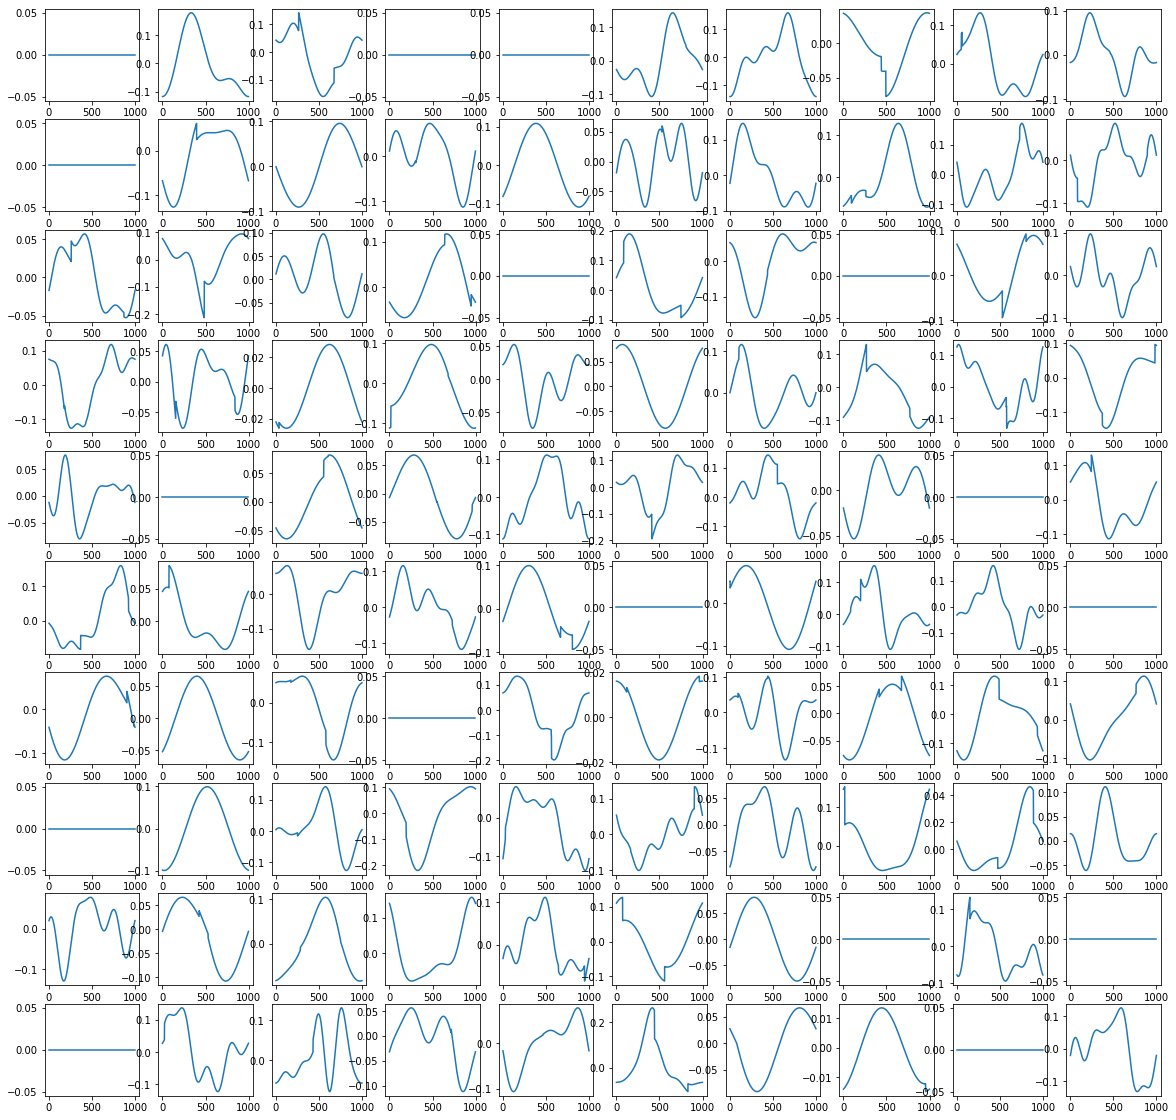

In [ ]:
#desmond 9h, léo 10h, guillaume jeudi. 
nx=1000
x=np.linspace(0,2*np.pi,nx)
imax=10
jmax=10
fig,axs=plt.subplots(imax,jmax,figsize=(20,20))
for i in range(imax):
    for j in range(jmax):
        axs[i,j].plot(generate_func(5,0,x))

In [ ]:
def Init_W(gamma, x, test_case):
    """ computes the initial conditions """

    if test_case == "Sod":

        # Sod test case
        Density  = 1 * ( x < 0.5 ) + 0.125 * ( x >= 0.5 )
        Velocity = 0 * x
        Pressure = 1 * ( x < 0.5 ) + 0.1 * ( x >= 0.5 )
        Momentum = Density * Velocity
        Energy   = Pressure / (gamma - 1.0) + 0.5 * Density * Velocity * Velocity

    elif test_case == "random":

        # Mach number and Fourier modes
        Mach = 10**np.random.uniform(np.log10(0.0001), np.log10(1000))
        Nmax = 8  

        # Density
        a0 = 2
        Density = generate_func(Nmax, a0, x)
        if np.min(Density) <= 0: 
            Density += -np.min(Density) + 1e-2

        # Velocity (rescaled with the Mach number)
        a0 = np.random.uniform(-1,1)
        Velocity = generate_func(Nmax, a0, x)
        Velocity *= min(Mach, 1.0)

        # Pressure (rescaled with the Mach number)
        a0 = 2
        Temperature = generate_func(Nmax, a0, x)
        s1 = np.random.uniform(0.1, 1)
        Pressure = Density * Temperature * s1 * min(1.0 / Mach, 1.0)
        if np.min(Pressure) <= 0: 
            Pressure += -np.min(Pressure) + 1e-2

        # Momentum and Energy 
        Momentum = Density * Velocity
        Energy = Pressure / (gamma - 1.0) + 0.5 * Density * Velocity * Velocity

    return Density, Momentum, Energy

In [ ]:
gamma=1.4
test_case="random"
W=np.empty([nx,3])
W[:,0], W[:,1], W[:,2] = Init_W(gamma, x, test_case)

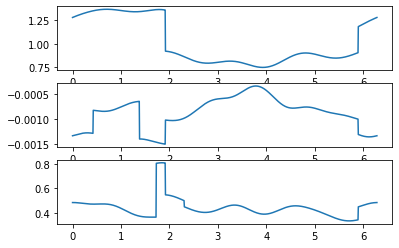

In [ ]:
fig,axs=plt.subplots(3,1)
axs[0].plot(x,W[:,0])
axs[1].plot(x,W[:,1])
axs[2].plot(x,W[:,2]);

## Fonctions utilitaires

Physique. 

* Vitesse du son 

In [ ]:
def get_Density(W):
    """ unpacks the vector W to get the Density """

    if len(np.shape(W)) == 1:
        return W[0]
    elif len(np.shape(W)) == 2:
        return W[:,0]

def unpack_W(W):
    """ unpacks the vector W to get Density, Momentum and Energy """

    if len(np.shape(W)) == 1:
        Density, Momentum, Energy = W
    elif len(np.shape(W)) == 2:
        Density = W[:,0]
        Momentum = W[:,1]
        Energy = W[:,2]

    return Density, Momentum, Energy

def compute_Velocity(W):
    """ computes the Velocity from the conserved variables W """

    Density, Momentum, Energy = unpack_W(W)
    return Momentum / Density

def compute_Sound_Speed( gamma, W ):
    """ computes the Sound Speed from the conserved variables W """

    return np.sqrt( gamma * compute_Pressure( gamma, W ) / get_Density(W) )

def compute_Pressure( gamma, W ):
    """ computes the Pressure from the conserved variables W """

    Density, Momentum, Energy = unpack_W(W)
    Velocity = Momentum / Density

    return ( gamma - 1 ) * ( Energy - 1/2 * Density * Velocity**2 )

def compute_Flux( gamma, W ):
    """ computes the physical Flux from the conserved variables W """

    Density, Momentum, Energy = unpack_W(W)

    Velocity = Momentum / Density
    Pressure = compute_Pressure( gamma, W )

    Flux_Density = Momentum
    Flux_Momentum = Density * Velocity**2 + Pressure
    Flux_Energy = Velocity * ( Energy + Pressure )

    return np.array([ Flux_Density, Flux_Momentum, Flux_Energy ]).T

## Conditions au limites

In [ ]:
def compute_Boundary_Conditions( W, BC_type = "periodic" ):
    """ computes the boundary conditions (periodic or Neumann), returns an array containing W and the two ghost cells """

    W_BC = np.zeros(( np.shape(W)[0] + 2, np.shape(W)[1] ))
    
    if BC_type == "periodic":
        W_BC[0] = W[-1]
        W_BC[-1] = W[0]
    elif BC_type == "Neumann":
        W_BC[0] = W[0]
        W_BC[-1] = W[-1]
    else:
        raise ValueError(" the boundary conditions {0} are not defined ".format(BC_type) )

    W_BC[1:-1] = W[:]

    return W_BC

## Solver

In [ ]:
def HLL_Wave_Speeds( gamma, W_L, W_R ):
    """ computes the HLL Wave Speeds """

    Density_L, Momentum_L, Energy_L = unpack_W(W_L)
    Density_R, Momentum_R, Energy_R = unpack_W(W_R)

    Velocity_L = compute_Velocity(W_L)
    Velocity_R = compute_Velocity(W_R)

    Sound_L = compute_Sound_Speed( gamma, W_L )
    Sound_R = compute_Sound_Speed( gamma, W_R )

    return ( np.minimum( Velocity_L - Sound_L, Velocity_R - Sound_R ), 
             np.maximum( Velocity_L + Sound_L, Velocity_R + Sound_R ) )

def HLL_Flux( gamma, Lambda_L, Lambda_R, W_L, W_R ):
    """ computes the HLL numerical Flux """

    F_L, F_R = compute_Flux( gamma, W_L ).T, compute_Flux( gamma, W_R ).T

    numerical_Flux = F_L * ( Lambda_L >= 0 ) \
                   + F_R * ( Lambda_R <= 0 ) \
                   + ( Lambda_R * F_L - Lambda_L * F_R + Lambda_L * Lambda_R * ( W_R - W_L ).T ) / ( Lambda_R - Lambda_L ) * np.logical_and( Lambda_L < 0, Lambda_R > 0 )

    return numerical_Flux.T

def update( time, CFL, dx, gamma, W, BC_type ):
    """ computes the solution at time t^{n+1} from the solution at time t^n """

    W_prev = compute_Boundary_Conditions( W, BC_type )

    Lambda_L, Lambda_R = HLL_Wave_Speeds( gamma, W_prev[:-1], W_prev[1:] )
    Flux = HLL_Flux( gamma, Lambda_L, Lambda_R, W_prev[:-1], W_prev[1:] )

    dt = CFL * dx / max( np.max( Lambda_L ), np.max( Lambda_R ) )

    return W - dt/dx * ( Flux[1:] - Flux[:-1] ), dt

## Projection

Le calcul des labels se fait sur une grille très fine. 
Le solver est fait sur une grille fine. 

On projette à la fin sur une grille grossière. 



In [ ]:
def project_to_coarse_grid(nx_coarse, nx_ratio, W):
    """ projects the fine solution to the coarse grid """

    # split the array W in "nx_coarse-1" chunks (of size ratio = nx // nx_coarse), and average each chunk
    return np.mean( np.array_split(W[nx_ratio//2:-nx_ratio//2], nx_coarse-1), axis=1)

def project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W, offset = 0):
    """ projects the fine solution to a coarse grid and keep only "points_to_save - 2" values """

    # after the projection, slice the array into "points_to_save" chunks
    W_proj = project_to_coarse_grid(nx_coarse, nx_ratio, W)[ : : nx_coarse // points_to_save ]

    # return a slice of W_proj, offset by -1, 0 or 1 (to eventually get W[i-1], W[i] and W[i+1])
    return W_proj[ 1 + offset : points_to_save - 1 + offset ]

def project_and_keep_points_and_add_values(points_to_save, nx_coarse, nx_ratio, W):
    """ projects the fine solution to a coarse grid, keep only "points_to_save" values, and add u, p, gamma """

    # project to the coarse grid, and keep only "points_to_save - 2" values
    W_im1_proj = project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W, offset = -1)
    W_i_proj   = project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W, offset =  0)
    W_ip1_proj = project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W, offset = +1)

    # create the arrays to be returned: add three columns for the Velocity, the Pressure, and gamma
    W_im1_proj_full = np.zeros(( np.shape(W_im1_proj) + np.array([0,3]) ))
    W_i_proj_full   = np.zeros(( np.shape(W_i_proj  ) + np.array([0,3]) ))
    W_ip1_proj_full = np.zeros(( np.shape(W_ip1_proj) + np.array([0,3]) ))

    # add the Velocity, the Pressure, and gamma
    for W_proj, W_proj_full in zip( [ W_im1_proj, W_i_proj, W_ip1_proj ], [ W_im1_proj_full, W_i_proj_full, W_ip1_proj_full ] ):
        W_proj_full[:,:3] = W_proj
        W_proj_full[:,3] = compute_Velocity(W_proj)
        W_proj_full[:,4] = compute_Pressure(gamma, W_proj)
        W_proj_full[:,5] = gamma

    return W_im1_proj_full, W_i_proj_full, W_im1_proj_full


## Création et enregistrement

### Paramètres

In [ ]:
test_case = "random"
#test_case = "Sod"

plot = True

xmin = 0
xmax = 1

# nx: number of points in the fine grid
nx = 4000 #30 000
dx = ( xmax - xmin ) / nx
x = np.arange( xmin, xmax, dx )

# nx_coarse: number of points in the coarse grid (must be an integer multiple of nx)
nx_coarse = 200 #600
dx_coarse = ( xmax - xmin ) / nx_coarse
x_coarse = np.arange( xmin, xmax, dx_coarse )

nx_ratio = nx // nx_coarse
if nx_ratio * nx_coarse != nx:
    raise ValueError(" the ratio between nx = {0} and nx_coarse = {1} must be an integer ".format( nx, nx_coarse ))

# we will save coarse data each "save_data_each"th point in space and each "time_steps_to_save"th time step
save_data_each = 5
points_to_save = nx_coarse // save_data_each
time_steps_to_save = points_to_save // 2

CFL = 0.5
gamma = 1.4

# W is the solution on the fine grid
W = np.zeros(( nx, 3 ))

if test_case == "Sod":
    BC_type = "Neumann"
elif test_case == "random":
    BC_type = "periodic"
else:
    raise ValueError(" test case {0} not defined ".format(test_case) )

### C'est parti

In [ ]:
# we will run "n_simulations" simulations
n_simulations = 50
i_simulation = 0
all_data = []#todo supprimer la liste

print("saving data for {0} simulations, each one involving {1} time steps and {2} space points".format(
    n_simulations, time_steps_to_save, points_to_save - 2
))

while i_simulation < n_simulations:

    # random initial condition
    W[:,0], W[:,1], W[:,2] = Init_W(gamma, x, test_case)

    time = 0
    time_iter = 0

    # the list "array_to_save" will be filled as the time loop advances
    array_to_save = []#todo supprimer la liste

    # we save "time_steps_to_save" time steps
    while (len(array_to_save) < time_steps_to_save ):

        # save solution every "2 * nx // points_to_save"-th time iteration
        if ( time_iter % ( 2 * nx // points_to_save ) == 0 ):

            # get the values of the projections of W[i-1], W[i] and W[i+1] at time t^n
            W_im1_n_proj, W_i_n_proj, W_ip1_n_proj = project_and_keep_points_and_add_values(points_to_save, nx_coarse, nx_ratio, W)

            # update W in time
            W, dt = update( time, CFL, dx, gamma, W, BC_type )

            # get the values of the projection of W[i] at time t^n
            W_i_np1_proj = project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W)

            # compute the physical Flux F_i^n and the difference of numerical Fluxes ΔF = -Δx/Δt ( F_i^{n+1} - F_i^n )
            Physical_Flux_n = compute_Flux( gamma, W_i_n_proj[:,:3] )
            d_Numerical_Flux = - dx / dt * ( W_i_np1_proj - W_i_n_proj[:,:3] )

            # stack the fluxes to get a (points_to_save,6)-shaped array, like each W_im1_n_proj, W_i_n_proj, W_ip1_n_proj
            Fluxes = np.hstack(( Physical_Flux_n, d_Numerical_Flux ))

            # add the values to be saved to array_to_save
            array_to_save += [np.array([ W_im1_n_proj, W_i_n_proj, W_ip1_n_proj, Fluxes ])]

        # only update if the solution is not saved
        else:
            W, dt = update( time, CFL, dx, gamma, W, BC_type )
            
        time += dt
        time_iter += 1

    array_to_save = np.array(array_to_save)

    # check for nans in the final array
    nan_in_array = False
    for val in array_to_save.flat:
        if np.isnan(val):
            nan_in_array = True
            break

    # is more than one time iteration was performed and no nans are present in the array, add it to all the simulation data
    if ( time_iter > 1 ) and (not nan_in_array):
        i_simulation += 1
        all_data += [array_to_save]
        print("simulation #{0:3d} done".format(i_simulation))

# save the simulation data to the file "filename"
filename = "data.npy"
np.save(filename, all_data)
print("saved data of shape {0} to file {1}".format(np.shape(all_data), filename))


saving data for 50 simulations, each one involving 20 time steps and 38 space points
simulation #  1 done
simulation #  2 done
simulation #  3 done
simulation #  4 done
simulation #  5 done
simulation #  6 done
simulation #  7 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


simulation #  8 done
simulation #  9 done
simulation # 10 done
simulation # 11 done
simulation # 12 done
simulation # 13 done
simulation # 14 done
simulation # 15 done
simulation # 16 done
simulation # 17 done
simulation # 18 done
simulation # 19 done
simulation # 20 done
simulation # 21 done
simulation # 22 done
simulation # 23 done
simulation # 24 done
simulation # 25 done
simulation # 26 done
simulation # 27 done
simulation # 28 done
simulation # 29 done
simulation # 30 done
simulation # 31 done
simulation # 32 done
simulation # 33 done
simulation # 34 done
simulation # 35 done
simulation # 36 done
simulation # 37 done
simulation # 38 done
simulation # 39 done
simulation # 40 done
simulation # 41 done
simulation # 42 done
simulation # 43 done
simulation # 44 done
simulation # 45 done
simulation # 46 done
simulation # 47 done
simulation # 48 done
simulation # 49 done
simulation # 50 done
saved data of shape (50, 20, 4, 38, 6) to file data.npy


## Récupération

In [ ]:
# load the simulation data from the file "filename"
filename = "data.npy"
all_data = np.load(filename)

# get the number of simulations, time steps and space points from the data
n_simulations = np.shape(all_data)[0]
n_time_steps  = np.shape(all_data)[1]
n_space_saves = np.shape(all_data)[3]

print("loading data for {0} simulations, each one involving {1} time steps and {2} space points".format(
    n_simulations, n_time_steps, n_space_saves
))

# create the arrays corresponding to the data to be recovered
W_im1_n_proj = np.empty((n_simulations, n_time_steps, n_space_saves, 6))     #w_-
W_i_n_proj   = np.empty((n_simulations, n_time_steps, n_space_saves, 6))     #w
W_ip1_n_proj = np.empty((n_simulations, n_time_steps, n_space_saves, 6))     #w_+
Physical_Flux_n  = np.empty((n_simulations, n_time_steps, n_space_saves, 3)) #y_f
d_Numerical_Flux = np.empty((n_simulations, n_time_steps, n_space_saves, 3)) #y_t

# loop through "all_data" to recover the simulation data
for i_simu, array_simu in enumerate(all_data):
    for i_time, val_time in enumerate(array_simu):
        W_im1_n_proj[i_simu, i_time], W_i_n_proj[i_simu, i_time], W_ip1_n_proj[i_simu, i_time], Fluxes = val_time
        Physical_Flux_n[i_simu, i_time] = Fluxes[:,:3]
        d_Numerical_Flux[i_simu, i_time] = Fluxes[:,3:]

print("loading done")


loading data for 50 simulations, each one involving 20 time steps and 38 space points
loading done


## Plot

Afficher la densité, la vitesse, la pression, 
au temps final, sur la grille fine pour W et W_ini, et W_proj la projection sur la grille grossière. 

NameError: ignored

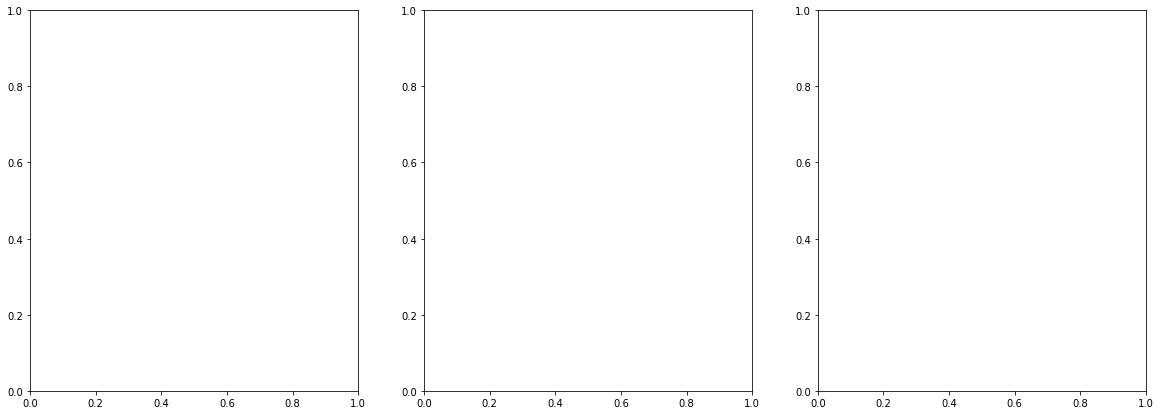

In [ ]:
if plot:

    fig, ax = plt.subplots( 1, 3, figsize = (20,7) )

    for x_, W_, legend in zip( [ x, x, x_coarse ], [ W, W_ini, W_proj ], [ "fine", "initial", "proj" ] ):
        ax[0].plot( x_, get_Density(W_), label = r"{0} $\rho$".format(legend) );
        ax[1].plot( x_, compute_Velocity(W_), label = r"{0} $u$".format(legend) );
        ax[2].plot( x_, compute_Pressure( gamma, W_ ), label = r"{0} $p$".format(legend) );
        [ ax[i].legend() for i in range(len(ax)) ]